# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!pip install -U matplotlib==2.0.2

Requirement already up-to-date: matplotlib==2.0.2 in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: six>=1.10 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
Requirement already up-to-date: numpy>=1.7.1 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
Requirement already up-to-date: pytz in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
Requirement already up-to-date: cycler>=0.10 in /opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg (from matplotlib==2.0.2)
Requirement already up-to-date: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,!=2.1.6,>=1.5.6 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
Requirement already up-to-date: python-dateutil in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

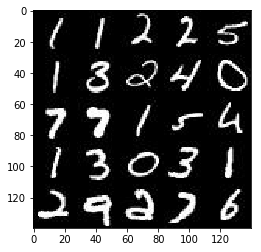

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

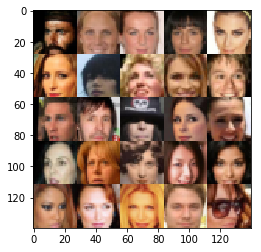

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, alpha*x1)
        # now size is 14*14*32
        x2 = tf.layers.conv2d(x1, 64, 5, strides=1, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, alpha*x2)
        # now size is 14*14*64
        x3 = tf.layers.conv2d(x2, 128, 5, strides=2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, alpha*x3)
        # now size is 7*7*128
        x4 = tf.layers.conv2d(x3, 256, 4, strides=1, padding='valid', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(x4, alpha*x4)
        # now size is 4*4*256
        x5 = tf.contrib.layers.flatten(x4)
        logits = tf.layers.dense(x5,1)
        out = tf.nn.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(inputs=z, units=4*4*512)
        x1 = tf.reshape(x1, (-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha*x1)
        # (-1,4,4,512)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha*x2)
        # (-1, 7, 7, 256)
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=1, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha*x3)
        # (-1, 7, 7, 256)
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=(2, 2), padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, alpha*x4)
        # (-1, 14, 14, 128)
        logits =tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=(2, 2), padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())  
        out = tf.tanh(logits)
        # (-1, 28, 28, 3)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model_out = generator(input_z, out_channel_dim, is_train=True)
    _, d_model_logits_real = discriminator(input_real, reuse=False)
    _, d_model_logits_fake = discriminator(g_model_out, reuse=True)
    
    # try label smoothing for d_loss_real
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_logits_real)*(1-smooth), 
                                                                         logits=d_model_logits_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_model_logits_fake),
                                                                         logits=d_model_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_logits_fake),
                                                                    logits=d_model_logits_fake))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    g_vars = [v for v in variables if v.name.startswith('generator')]
    d_vars = [v for v in variables if v.name.startswith('discriminator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = batch_images * 2
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                # print current loss
                print_every = 10
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show artificial images
                show_every = 100
                if steps % show_every == 0:
                    show_generator_output(sess, 12, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3808... Generator Loss: 0.1966
Epoch 1/2... Discriminator Loss: 1.6876... Generator Loss: 0.3465
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 4.2903
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 2.4256
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 5.1149
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 10.8551
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 8.7150
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 4.9994
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 5.6114
Epoch 1/2... Discriminator Loss: 0.6497... Generator Loss: 1.8675


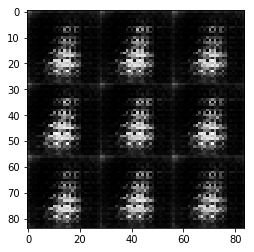

Epoch 1/2... Discriminator Loss: 0.4811... Generator Loss: 2.7037
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 1.3887
Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.7791
Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 3.1771
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 3.3926
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 2.4817
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 2.3321
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 2.2319
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 2.5519
Epoch 1/2... Discriminator Loss: 0.7155... Generator Loss: 1.8193


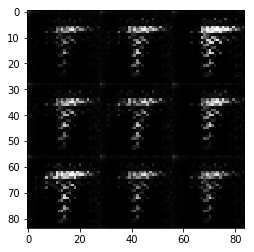

Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 2.6033
Epoch 1/2... Discriminator Loss: 0.6466... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.7769
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 0.8155... Generator Loss: 2.0389
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 2.4543
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 2.2635
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 2.2170
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 1.9888
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.6962


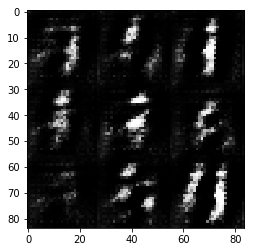

Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 1.0542
Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 2.3913
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.7935
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.4843
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.4995
Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 1.5639
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.9500
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.3270
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.7530


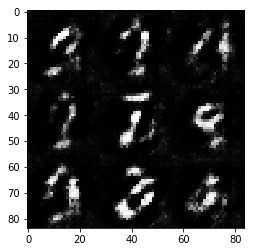

Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.9558
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.3292
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 1.0051... Generator Loss: 1.3759
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 1.3684
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.6837


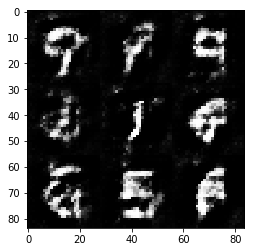

Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 1.8157
Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 1.1860
Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 1.4261
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.0729
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 1.3073
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.6456


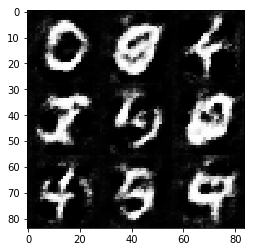

Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 1.9737
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 1.6996
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.1727
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.1953
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.1239


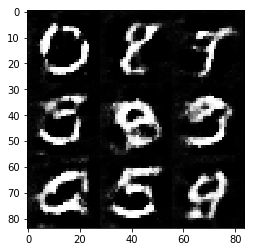

Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.9124
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.4090


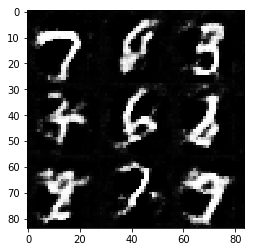

Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 1.5801
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.1856
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 1.3868
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.4857
Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8351


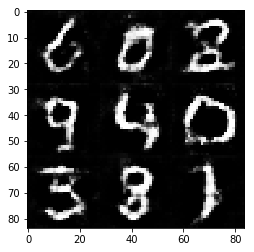

Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.0856
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.1369
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 2.3818


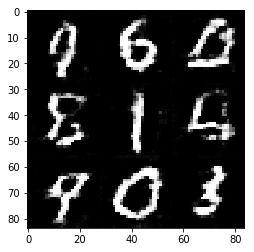

Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.2441
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.4046
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 2.0915... Generator Loss: 0.3097
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.1204
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 2.3654


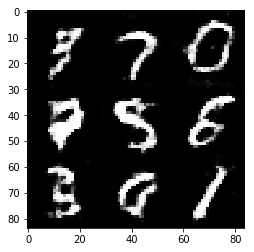

Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 1.3955
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.1679
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.6372
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.4928


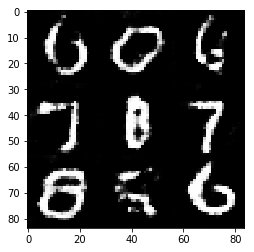

Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.1803
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.0521
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 1.0977


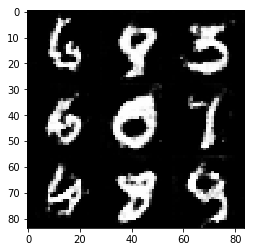

Epoch 2/2... Discriminator Loss: 1.7472... Generator Loss: 2.6752
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.8977
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8868
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.2893


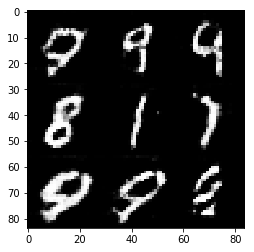

Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 1.7658... Generator Loss: 0.4225
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 0.9775


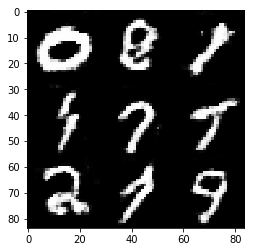

Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.3775
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.2313
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6058
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.0232
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.5086
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.8314


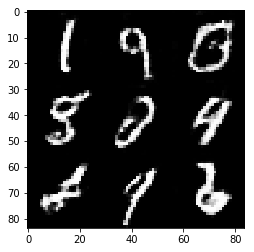

Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.7898
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.2796
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 1.3971
Epoch 2/2... Discriminator Loss: 1.7537... Generator Loss: 0.3627
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 2.0065... Generator Loss: 4.1099


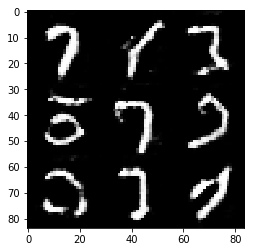

Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 1.6534
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.2738
Epoch 2/2... Discriminator Loss: 1.6780... Generator Loss: 2.8083
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.7518
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.1415
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.8247
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 3.0800


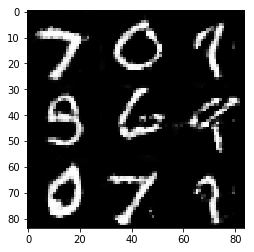

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 1.0241
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.2642
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 1.1198
Epoch 2/2... Discriminator Loss: 1.4547... Generator Loss: 0.5319
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 1.0096
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8386


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.0738... Generator Loss: 0.1035
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.4958
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.5744
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.9412
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 1.8696
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 7.7818
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.3168


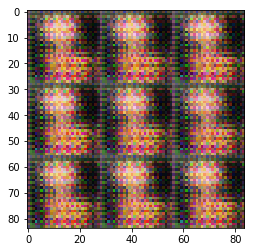

Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 7.1682
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 3.9324
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.4474
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 2.6222
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.5322
Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 2.4817


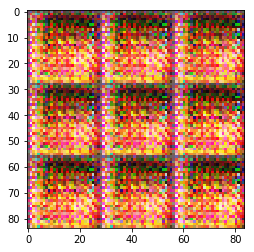

Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 2.6084
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.3786


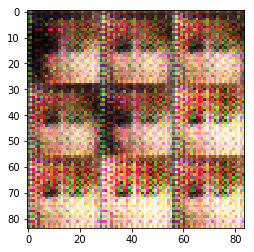

Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.9138
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 2.1387
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.4587


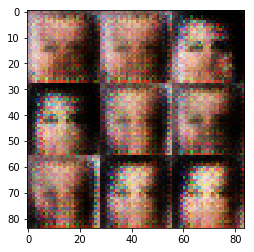

Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.4463
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.9083


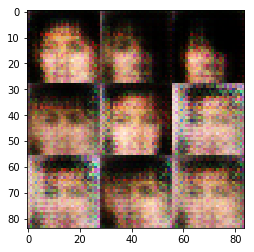

Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.4983


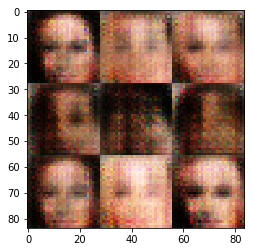

Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0296


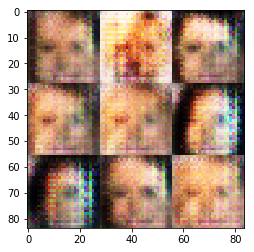

Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6788


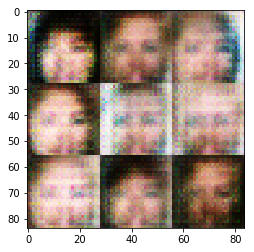

Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.9114


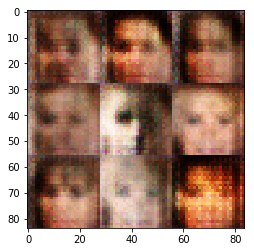

Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.9771


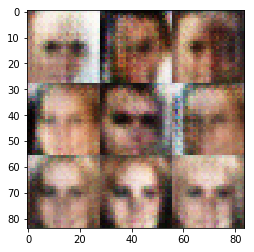

Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.9878


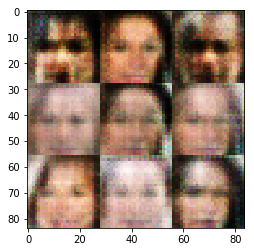

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.7737


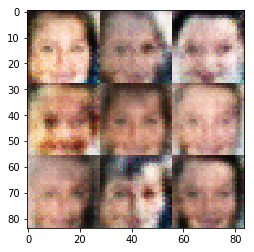

Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8224


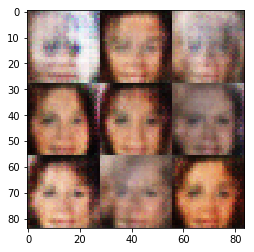

Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.0033


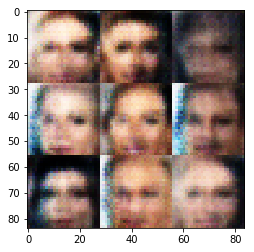

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.1092


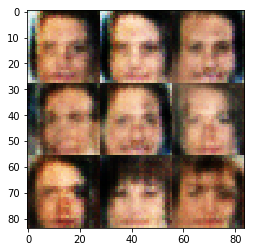

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8765


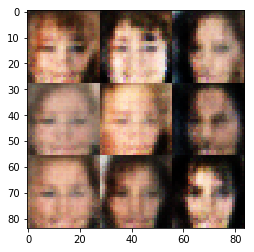

Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6699


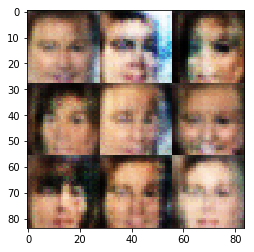

Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 1.0556


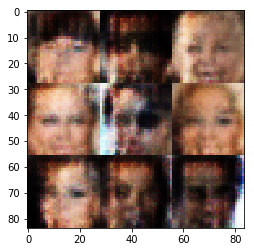

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.9163


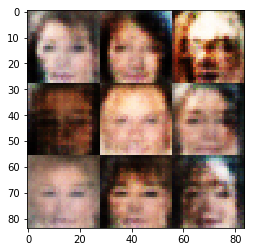

Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6936


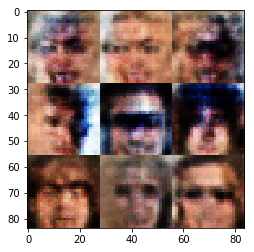

Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.0284


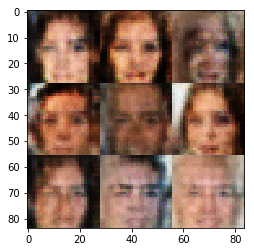

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.5888


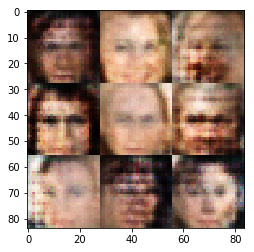

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7833


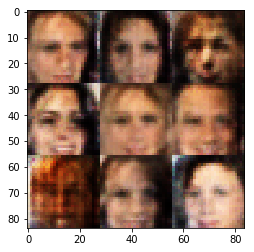

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0009


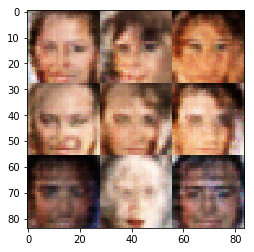

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 1.3285
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.5459
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.9337


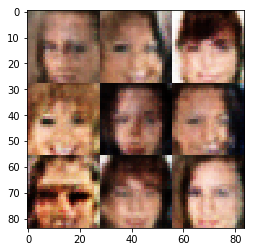

Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.9996


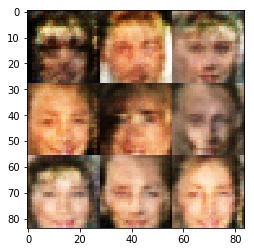

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9749


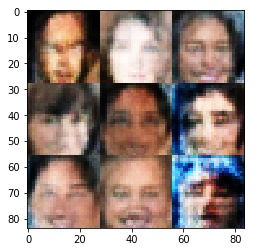

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.8615


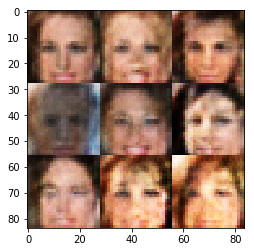

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9067


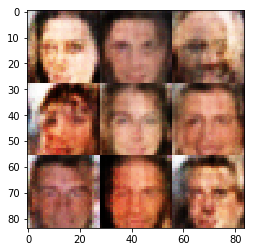

Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.4261
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7636


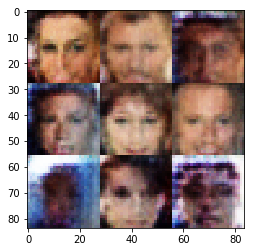

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.0504


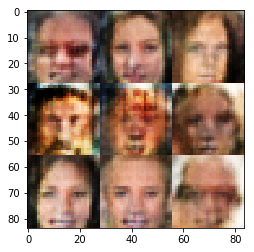

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8945


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.